In [1]:
import os
import glob
import cv2
import re
import gc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import os
os.chdir('../../')

In [2]:
train_list = open('./data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt')
train_list = train_list.readlines()

test_list = open('./data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt')
test_list = test_list.readlines()
                  
train_list = [re.sub('\n', '', f) for f in train_list]
test_list = [re.sub('\n', '', f) for f in test_list]

train_df = pd.DataFrame(train_list, columns=['id'])
test_df = pd.DataFrame(test_list, columns=['id'])

train_df['ftype'] = 'train'
test_df['ftype'] = 'test'

data_df = pd.concat([train_df, test_df])


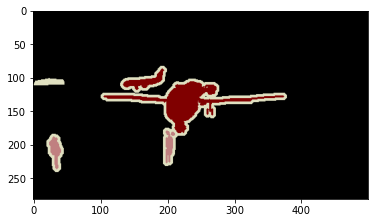

In [3]:
temp = './data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png'
temp = Image.open(temp)
plt.imshow(temp)

In [4]:
temp = np.array(temp)
np.unique(temp)

array([  0,   1,  15, 255], dtype=uint8)

In [5]:
masks = glob.glob('./data/VOCdevkit/VOC2012/SegmentationClass/*')
images = glob.glob('./data/VOCdevkit/VOC2012/JPEGImages/*')                  
print(len(images))
print(len(masks))
print(len(data_df))

17125
2913
2913


In [6]:
print(set([m.split('.')[-1] for m in masks]))
print(set([m.split('.')[-1] for m in images]))

{'png'}
{'jpg'}


In [7]:
image_dir = './data/VOCdevkit/VOC2012/JPEGImages/'
mask_dir = './data/VOCdevkit/VOC2012/SegmentationClass/'


In [8]:
data_df['image_loc'] = image_dir + data_df['id'] + '.jpg'
data_df['mask_loc'] = mask_dir + data_df['id'] + '.png'

In [9]:
print(len(train_list))
print(len(test_list))

1464
1449


In [10]:
# data_df.to_csv('.data_df.csv', index=False)

In [11]:
# label number infromation from
# https://bo-10000.tistory.com/38

labels_num = """Aeroplane	1
Bicycle	2
Bird	3
Boat	4
Bottle	5
Bus	6
Car	7
Cat	8
Chair	9
Cow	10
Diningtable	11
Dog	12
Horse	13
Motorbike	14
Person	15
Pottedplant	16
Sheep	17
Sofa	18
Train	19
Tvmonitor	20"""

labels_num = labels_num.lower().split('\n')
labels_num = [c.split('\t') for c in labels_num]
labels_num = np.array(labels_num)
label2num = dict(zip(labels_num[:,0], labels_num[:,1].astype(int)))
label2num['background'] = 0
label2num['border'] = 255

num2label = dict(zip(label2num.values(), label2num.keys()))


label_dict = {
    'label2num': label2num,
    'num2label': num2label
}
import pickle

label_dict_loc = './label_dict.pkl'

with open(label_dict_loc, 'wb') as f:
    pickle.dump(label_dict, f)

# with open(label_dict_loc, 'rb') as f:
#     check_dict = pickle.load(f)
# print(check_dict)

In [12]:
info_dict = {}

for i in tqdm(range(len(data_df))):
    cur_id = data_df.iloc[i]['id']
    img_loc = data_df.iloc[i]['image_loc']
    mask_loc = data_df.iloc[i]['mask_loc']


    # image = cv2.imread(img_loc)
    # image = image[:,:,::-1]

    mask = np.array(Image.open(mask_loc))
    mask_nums = np.unique(mask)

    h, w = mask.shape
    cur_meta = {}

    cur_meta['height'] = h
    cur_meta['width'] = w
    cur_meta['area'] = h * w


    for k in label2num.keys():
        cur_meta[f'{k}_sum'] = 0

    for num in mask_nums:
        pix_sum = np.sum(mask == num)
        cur_meta[f'{num2label[num]}_sum'] = pix_sum

    
    info_dict[cur_id] = cur_meta


100%|██████████████████████████████████████████████| 2913/2913 [00:06<00:00, 422.97it/s]


In [13]:

meta_df = pd.DataFrame(info_dict).T.reset_index()
meta_df = meta_df.rename(columns={'index':'id'})
meta_df = pd.merge(data_df, meta_df, on='id')

In [16]:
# meta_df.to_csv('./meta_df.csv', index=False)

In [10]:
train_df = pd.read_csv('./data/train_df.csv', index_col=0)
cnt_cols = [i for i in train_df.columns if 'cnt' in i]
cnt_cols = [i for i in cnt_cols if not ('background' in i) and not ('border' in i)]
pd.DataFrame(train_df[cnt_cols].sum())


,0
aeroplane_cnt,88
bicycle_cnt,65
bird_cnt,105
boat_cnt,78
bottle_cnt,87
bus_cnt,78
car_cnt,128
cat_cnt,131
chair_cnt,148
cow_cnt,64


In [17]:
sum_cols = [i for i in train_df.columns if 'sum' in i]
sum_cols = [i for i in sum_cols if not ('background' in i) and not ('border' in i)]



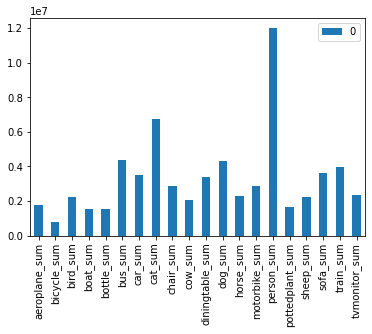

In [29]:
pd.DataFrame(train_df[sum_cols].sum()).plot(kind='bar')

In [32]:
prop_cols = [i for i in train_df.columns if 'prop' in i]
prop_cols = [i for i in prop_cols if not ('background' in i) and not ('border' in i)]



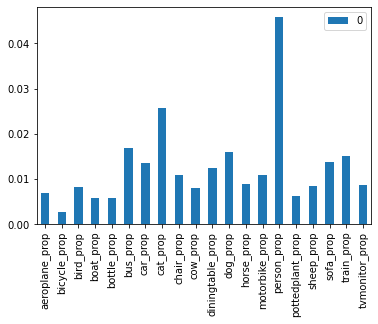

In [33]:
pd.DataFrame(train_df[prop_cols].mean()).plot(kind='bar')

- https://www.researchgate.net/figure/Evaluation-results-of-the-PASCAL-VOC-2012-test-set_tbl1_315635038

In [109]:
results_a = """Method Bkg Aero Bike Bird Boat Bottle Bus Car Cat Chair Cow
FCN-8s 91.2 76.8 34.2 68.9 49.4 60.3 75.3 74.7 77.6 21.4 62.5
FCN-GS 90.9 80.4 33.4 70.8 53.0 62.9 79.7 76.4 79.1 24.0 65.4
FCN-GS-v2 91.3 79.8 33.9 74.0 55.6 64.7 79.1 76.8 80.3 25.3 65.7
FCN-DBSCAN 91.2 82.2 33.1 73.3 55.6 63.3 79.8 76.1 78.3 24.5 64.8
FCN-DBSCAN-v2 92.0 78.5 32.4 76.9 56.6 64.6 80.6 74.7 77.8 26.7 68.4
DeepLab-CRF 92.1 78.4 33.1 78.2 55.6 65.3 81.3 75.5 78.6 25.3 69.2
DeepLab-CRF-GS 92.3 81.4 34.1 79.1 58.3 65.8 81.3 77.1 80.5 28.9 69.1
DeepLab-CRF-GS-v2 92.3 82.3 34.2 79.0 58.3 66.0 82.1 77.7 81.8 29.1 68.5"""

results_b = """Method Table Dog Horse Mbk Person Plant Sheep Sofa Train TV Mean
FCN-8s 46.8 71.8 63.9 76.5 73.9 45.2 72.4 37.4 70.9 55.1 62.2
FCN-GS 52.9 73.6 66.9 75.6 75.2 46.9 72.5 42.0 70.6 59.6 64.4
FCN-GS-v2 52.7 74.0 67.3 76.0 75.4 48.8 74.7 44.2 72.6 58.8 65.3
FCN-DBSCAN 53.6 73.9 66.6 76.9 75.0 47.6 73.2 43.4 73.2 59.0 65.0
FCN-DBSCAN-v2 52.1 73.6 68.6 78.4 76.8 54.0 76.9 46.1 72.2 57.3 65.9
DeepLab-CRF 52.7 75.2 69.0 79.1 77.6 54.7 78.3 45.1 73.3 56.2 66.4
DeepLab-CRF-GS 56.1 75.9 68.8 78.9 78.0 53.7 78.7 46.3 73.8 58.9 67.5
DeepLab-CRF-GS-v2 56.3 77.0 69.1 79.7 78.0 53.5 78.2 47.0 74.9 60.4 67.9"""

results_a = results_a.split('\n')
results_b = results_b.split('\n')
results_a = [i.split() for i in results_a]
results_b = [i.split() for i in results_b]

df_a = pd.DataFrame(results_a[1:], columns=results_a[0])
df_b = pd.DataFrame(results_b[1:], columns=results_b[0])

df_a = df_a.T
df_a.columns = df_a.iloc[0]
df_a = df_a.iloc[1:]

df_b = df_b.T
df_b.columns = df_b.iloc[0]
df_b = df_b.iloc[1:]

result_df = pd.concat([df_a,df_b])
result_df = result_df.astype(float)

In [110]:
from utils.util import get_labedict
labeldict = get_labedict()
label2num = labeldict['label2num']
num2label = labeldict['num2label']
labels = ['background']+list(label2num.keys())[:-2]

In [113]:

result_df.index = labels + ['mean']

In [126]:
result = result_df['DeepLab-CRF-GS-v2'].values[1:-1] # remove background, mean
prop_mean = train_df[prop_cols].mean().values # non-zero mean
pix_sum = train_df[sum_cols].sum()


In [133]:
data = np.array([result, prop_mean])
np.corrcoef(data[0][1])

array([[1.        , 0.35477797],
       [0.35477797, 1.        ]])

In [134]:
data = np.array([result, pix_sum])
np.corrcoef(data[0][1])

/home/nys/anaconda3/envs/my_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/nys/anaconda3/envs/my_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/nys/anaconda3/envs/my_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


nan

In [146]:
def calc_corr(a, b):
    cov = np.cov(a, b, ddof=len(a)-1)
    a_sd = np.std(a, ddof=len(a)-1)
    b_sd = np.std(b, ddof=len(b)-1)
    return (cov/(a_sd * b_sd))

In [147]:
calc_corr(pix_sum, result)

array([[1.53591764e+05, 3.52824292e-01],
       [3.52824292e-01, 6.51076578e-06]])

# for copy & paste

In [18]:
img_loc = data_df.iloc[0]['image_loc']
mask_loc = data_df.iloc[0]['mask_loc']

In [19]:
image = cv2.imread(img_loc)
image = image[:,:,::-1]

mask = np.array(Image.open(mask_loc))

mask_classes = np.unique(mask)


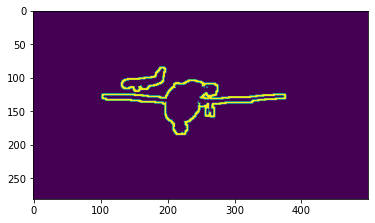

In [21]:
airplane = (mask == 1).astype(np.uint8)
airplane_xy = np.where(airplane == 1)

kernel = np.ones((7,7), np.uint8)
result = cv2.dilate(airplane, kernel, iterations = 1)
result[airplane_xy] = 0
plt.imshow(result)

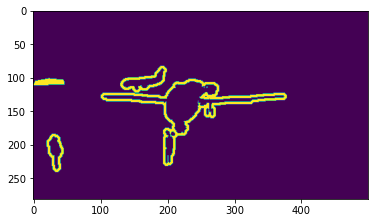

In [22]:
plt.imshow(mask==255)

- https://jhtechblog.tistory.com/entry/ErosionDilationOpeningClosingOpenc
- 

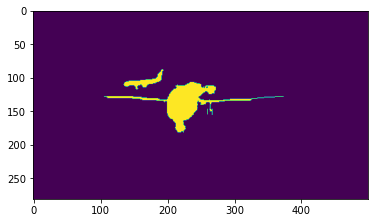

In [24]:

contours, hierarchy = cv2.findContours(airplane, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

contour_img = cv2.drawContours(airplane.copy(), contours, -1, (0,255,0), 1)
plt.imshow(contour_img)




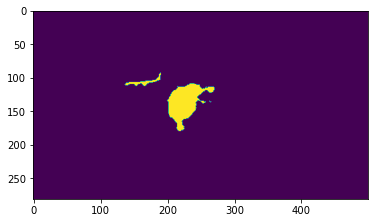

In [25]:

contours, hierarchy = cv2.findContours(airplane, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 

contour_img = cv2.drawContours(airplane.copy(), contours, -1, (0,255,0), 3)
plt.imshow(contour_img)




In [26]:
contour_img.shape

(281, 500)

In [27]:
from skimage import segmentation

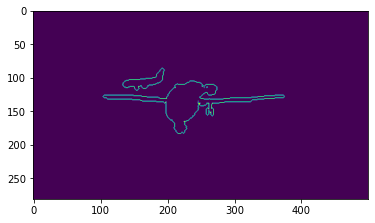

In [28]:

a = segmentation.find_boundaries(airplane, mode='outer')

plt.imshow(a)


# check

In [29]:
%%timeit 
image = cv2.imread(img_loc)
image = image[:,:,::-1]

1.43 ms ± 5.29 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
%%timeit 
image = cv2.imread(img_loc)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

2.02 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [31]:
image = cv2.imread(img_loc)
print(id(image))
image = image[:,:,::-1]
print(id(image))

139653117991792
139653596293712


In [32]:
image = cv2.imread(img_loc)
print(id(image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(id(image))

139653117992848
139653596293712
